## We start by importing all of the libaries and functions we'll need 

In [222]:
# System tools
import os

# Data analysis
import pandas as pd
from collections import Counter
from itertools import combinations 
from tqdm import tqdm

# NLP
import spacy
nlp = spacy.load("en_core_web_sm")

# drawing
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

## Define input file and read data to dataframe

In [223]:
input_file = os.path.join("..", "data", "labelled_data", "fake_or_real_news.csv")

In [224]:
data = pd.read_csv(input_file)

## Extract all named individuals

We use ```spaCy``` to extract only mentions of PERSONS in the texts.

NB: See final comment below under ```Problems```!

In [ ]:
real_df = data[data["label"]=="REAL"]["text"]

In [225]:
text_entities = []

for text in tqdm(real_df):
    # create temporary list 
    tmp_entities = []
    # create doc object
    doc = nlp(text)
    # for every named entity
    for entity in doc.ents:
        # if that entity is a person
        if entity.label_ == "PERSON":
            # append to temp list
            tmp_entities.append(entity.text)
    # append temp list to main list
    post_entities.append(tmp_entities)

100%|██████████| 3171/3171 [09:26<00:00,  5.60it/s]


## Create edgelist using ```itertools.combinations()```

In [205]:
edgelist = []
# iterate over every document
for text in text_entities:
    # use itertools.combinations() to create edgelist
    edges = list(combinations(text, 2))
    # for each combination - i.e. each pair of 'nodes'
    for edge in edges:
        # append this to final edgelist
        edgelist.append(tuple(sorted(edge)))

## Count occurrences using ```Counter()```

Create DF from Counter object, showing each node pair and the edge weight.

In [206]:
counted_edges = []
for key, value in Counter(edgelist).items():
    source = key[0]
    target = key[1]
    weight = value
    counted_edges.append((source, target, weight))

In [207]:
edges_df = pd.DataFrame(counted_edges, columns=["nodeA", "nodeB", "weight"])

__Filter based on edgeweight__

In [228]:
filtered = edges_df[edges_df["weight"]>500]

## Create network

Create a graph object called ```G```

In [209]:
G=nx.from_pandas_edgelist(filtered, 'nodeA', 'nodeB', ["weight"])

The process below uses ```pygraphviz``` to plot an output and then ```matplotlib``` to save to a .png file.

If you work on Windows, you might encounter problems with ```pygraphviz```- in that case, just use the regular ```matplotlib``` graphing functions in ```networkx```.

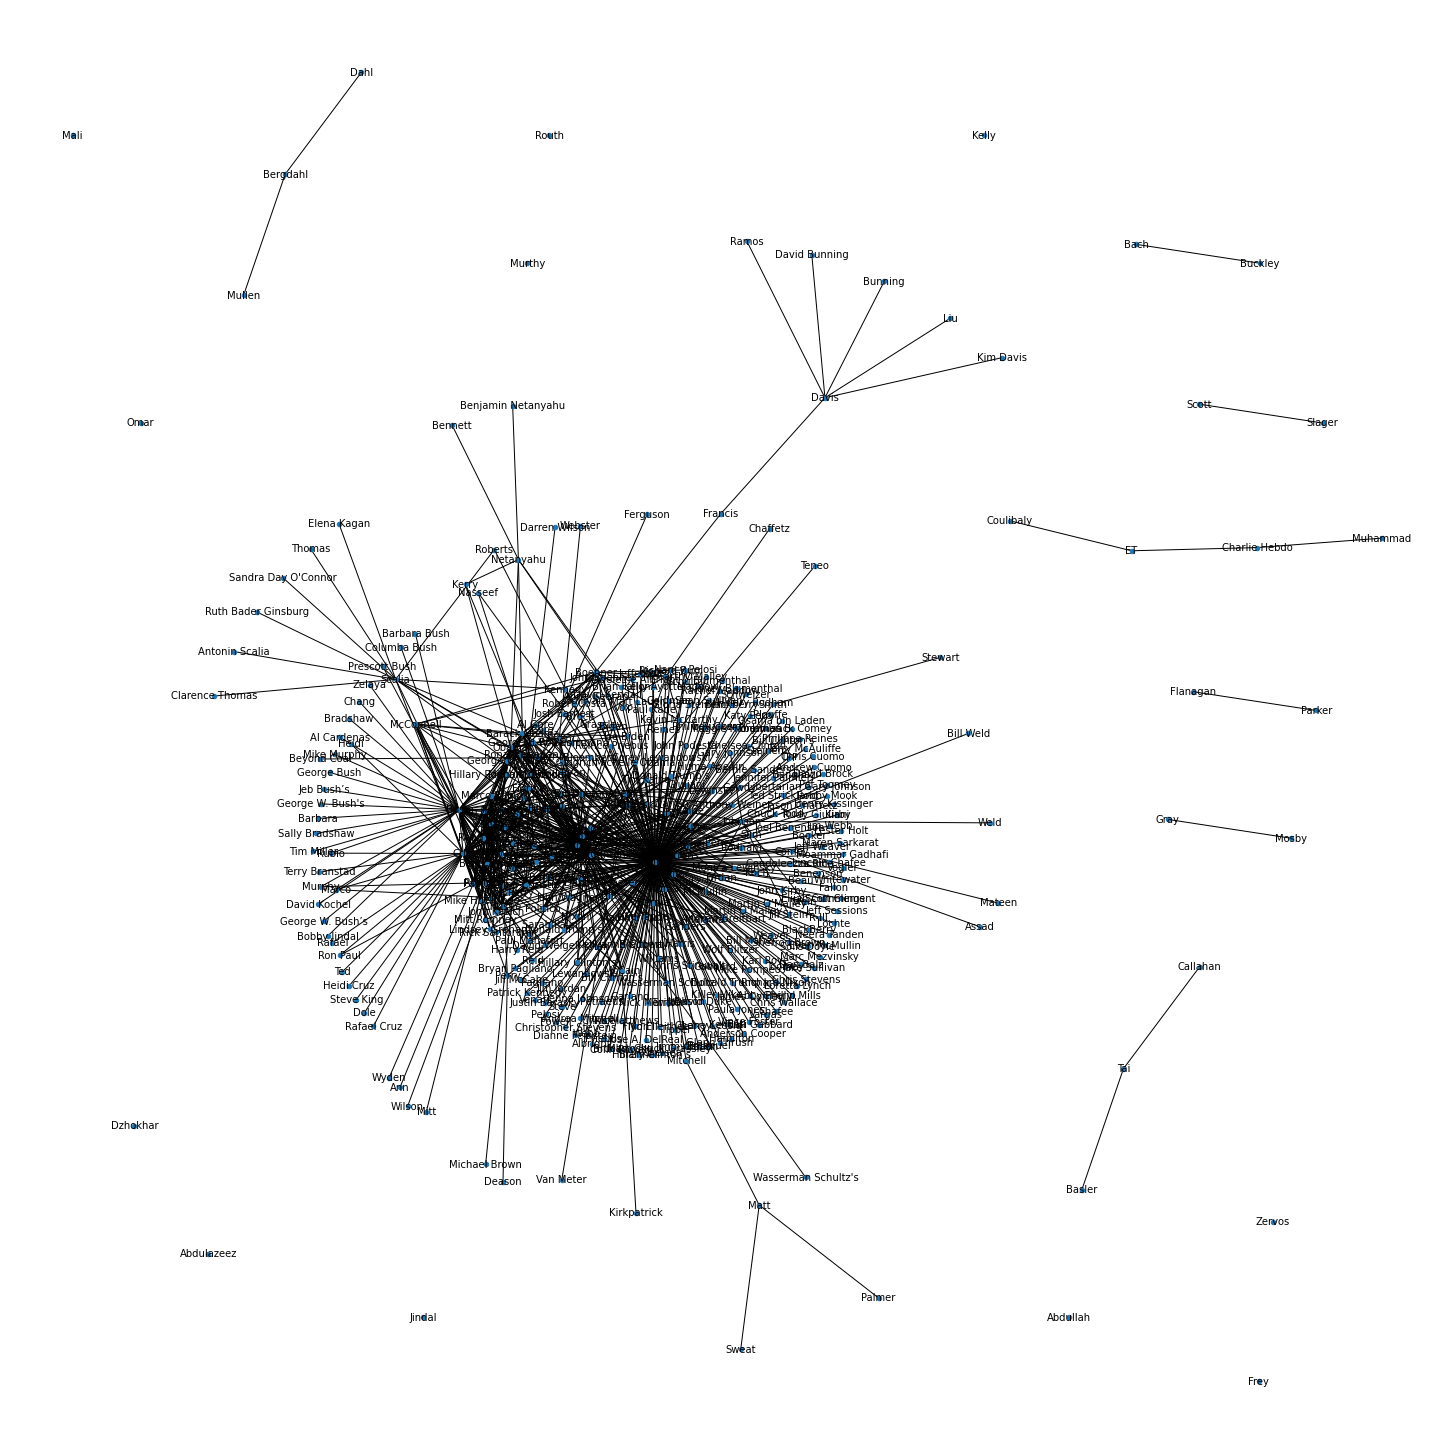

In [210]:
# Plot it
pos = nx.nx_agraph.graphviz_layout(G, prog="neato")

Make sure the folder ```../viz``` exists already for saving the image

In [ ]:
outpath_viz = os.path.join('..', 'viz',' network.png')

In [ ]:
nx.draw(G, pos, with_labels=True, node_size=20, font_size=10)
plt.savefig(outpath_viz, dpi=300, bbox_inches="tight")

## Centrality measures

In [215]:
ev = nx.eigenvector_centrality(G)

In [220]:
pd.DataFrame(ev.items()).sort_values("weight", ascending=False)

In [ ]:
bc = nx.betweenness_centrality(G)

In [221]:
pd.DataFrame(bc.items()).sort_values("weight", ascending=False)

## Problems

- How much of an issue is coreference in the data?

- We've said that we're basing this on document co-occurence. But then why are there some node pairs with a greater edge weight than the number of documents?

- We could resolve this by changing the final line of our ```spaCy``` pipeline to be something like ```post_entities.append(set(sorted(tmp_entities)))```. 
    - What does this code do?